# Cross-correlation between song and spike density functions (firing rates)


<img src="img/song_fr_cross_corr_example.png" width=500 height=700 />

- Read results values from song_fr_cross_corrsong_fr_cross_corr table
- Compare peak latency & max value of the mean cross-correlation between binarized song and firing rates

In [1]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from util import save
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

## Load Data

In [2]:
from database.load import ProjectLoader
db = ProjectLoader().load_db()
df = db.to_dataframe(f"""SELECT song_fr_cross_corr.*, cluster.birdID, cluster.taskName
                FROM song_fr_cross_corr INNER JOIN cluster ON cluster.id = song_fr_cross_corr.clusterID""")
df.set_index('clusterID')

,nbMotifUndir,crossCorrMax,peakLatency,birdID,taskName
clusterID,,,,,
6,27,0.451,83.0,b70r38,Postdeafening
9,21,0.429,-18.0,b70r38,Postdeafening
10,43,0.511,-10.0,b70r38,Postdeafening
11,27,0.377,-38.0,b70r38,Postdeafening
12,70,0.488,-31.0,b70r38,Postdeafening
...,...,...,...,...,...
124,34,0.477,-7.0,k27o36,Postdeafening
126,13,0.423,30.0,k27o36,Postdeafening
129,20,0.559,-50.0,o25w75,Postdeafening


In [3]:
df.columns

Index(['clusterID', 'nbMotifUndir', 'crossCorrMax', 'peakLatency', 'birdID',
       'taskName'],
      dtype='object')

# Compare peak latency vs. max cross-correlation 

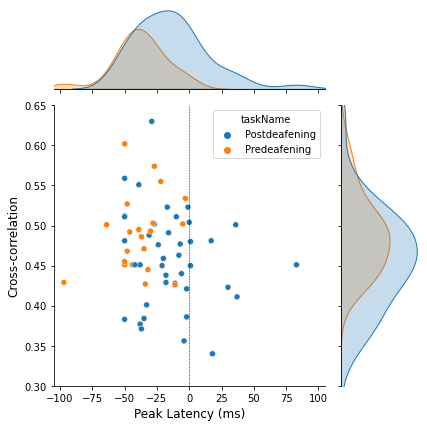

In [4]:
# V1
h = sns.jointplot(x="peakLatency", y="crossCorrMax", data=df,
                  hue='taskName',
#                   s=30, 
                  legend=True, 
                  height=6, ratio=3, 
                  xlim=(-105, 105), ylim=(0.3, 0.65)
                  )

h.set_axis_labels('Peak Latency (ms)', 'Cross-correlation', fontsize=12)
h.ax_joint.axvline(x=0, linestyle = '--', color = 'k', linewidth = 0.5)
plt.show()

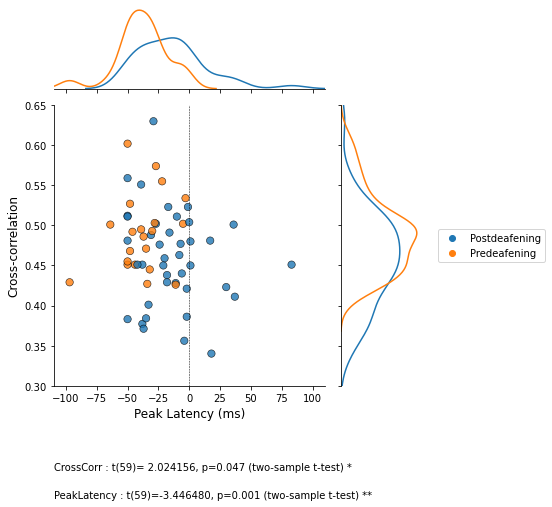

In [39]:
# V2
# Parameters
save_fig = False
fig_ext = '.png'
save_path = save.make_dir(ProjectLoader().path / 'Analysis', 'SongFR_CrossCorr', add_date=False)
kernel_bw = 0.4
fig_size = 6
mark_birds = False  # mark birds with a different marker style
fig_name = 'song_fr_cross_corr'

marker_style = 'birdID' if mark_birds else None

g = sns.JointGrid(x="peakLatency", y="crossCorrMax",  data=df, xlim=(-110, 110), ylim=(0.3, 0.65), height=fig_size, ratio=3)
g.plot_joint(sns.scatterplot, 
             hue='taskName', 
             style=marker_style, 
             s=55, 
             alpha=0.8,
             edgecolor="black",
             data=df, legend=True)

# plot legend on the right
if marker_style:
    handles, labels = g.ax_joint.get_legend_handles_labels()
    order = np.array(range(0, len(labels)))  #specify order of items in legend
    np.put(order, [0, 1, 2], [0, 2, 1])
    g.ax_joint.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
              loc='center left', bbox_to_anchor=(1.4, 0.5)
              ) 
else: 
    g.ax_joint.legend(loc='center left', bbox_to_anchor=(1.4, 0.5)) 

# plot density function
sns.kdeplot(df.loc[df['taskName']=='Postdeafening', 'peakLatency'], ax=g.ax_marg_x, bw=kernel_bw)
sns.kdeplot(df.loc[df['taskName']=='Predeafening', 'peakLatency'], ax=g.ax_marg_x, bw=kernel_bw)
sns.kdeplot(df.loc[df['taskName']=='Postdeafening', 'crossCorrMax'], ax=g.ax_marg_y, vertical=True, bw=kernel_bw)
sns.kdeplot(df.loc[df['taskName']=='Predeafening', 'crossCorrMax'], ax=g.ax_marg_y, vertical=True, bw=kernel_bw)

g.ax_joint.axvline(x=0, linestyle = '--', color = 'k', linewidth = 0.5)
g.set_axis_labels('Peak Latency (ms)', 'Cross-correlation', fontsize=12)

# run stats
from util.stats import two_sample_ttest, paired_ttest, rank_sum_test, signed_rank_test
pre = df.query('taskName == "Predeafening"')['crossCorrMax']
post = df.query('taskName == "Postdeafening"')['crossCorrMax']
_, _, msg, sig = two_sample_ttest(pre, post)
g.ax_joint.text(0, -0.3, 'CrossCorr : ' + msg + " (two-sample t-test) " + sig, transform=g.ax_joint.transAxes)

pre = df.query('taskName == "Predeafening"')['peakLatency']
post = df.query('taskName == "Postdeafening"')['peakLatency']
_, _, msg, sig = two_sample_ttest(pre, post)
g.ax_joint.text(0, -0.4, 'PeakLatency : ' + msg + " (two-sample t-test) " + sig, transform=g.ax_joint.transAxes)

if save_fig:
    save.save_fig(fig, save_path, fig_name, view_folder=view_folder, fig_ext=fig_ext)
else:
    plt.show()